In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import math
#import cv2
%matplotlib inline

cwd = os.getcwd()
data_dir = os.path.join(os.path.dirname(cwd), 'data')
input_dir = os.path.join(os.path.dirname(cwd), 'data', 'imgs')
output_dir = os.path.join(os.path.dirname(cwd), 'data', 'for_bb')
TARGET_WIDTH = 300
TARGET_HEIGHT = 268

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
data_dir

'/home/ubuntu/courses/deeplearning1/nbs/data'

In [3]:
input_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/imgs'

In [4]:
output_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/for_bb'

In [5]:
cwd

'/home/ubuntu/courses/deeplearning1/nbs/whale_recognition'

In [6]:
ann = pd.read_csv(os.path.join(cwd, 'bonnet_and_bbox.csv'))

In [7]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,1370.097707,1647.792622,1108.737787
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,908.634098,1345.595214,963.764706
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982


In [8]:
def find_new_bb(r, target_width, target_height):
    #print(r) 
    width_ratio = (target_width * 1.0) / r.image_width
    height_ratio = (target_height * 1.0) / r.image_height 
    
    bboxx_new = width_ratio * r.bboxx
    
    
    bboxy_new = height_ratio * r.bboxy
    
    width_final = width_ratio * r.width
    height_final = height_ratio * r.height
    
    
    return [r.Image,bboxx_new, bboxy_new, width_final, height_final]

In [9]:
bb_vals = ann.apply(lambda r: find_new_bb(r, TARGET_WIDTH, TARGET_HEIGHT), axis=1)

In [10]:
bb_vals = np.array([np.array(l) for l in bb_vals.values])

In [11]:
bb_vals = pd.DataFrame(bb_vals, columns=['Image','bboxx_new', 'bboxy_new', 'width_new', 'height_new'])

In [12]:
ann = ann.merge(bb_vals, on ='Image' )

In [13]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,1370.097707,1647.792622,1108.737787,137.826521115,128.932809753,49.4095075696,66.2087401433
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114,116.417901586,133.275580405,61.4173181593,62.6456645225
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,908.634098,1345.595214,963.764706,103.584432119,108.09447996,58.667288988,60.1889717961
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173,146.162877003,128.821596863,32.9673366109,46.6476286005
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982,137.402326015,84.336441112,42.8805916758,70.4348299398


In [71]:
def crop(r, target_width, target_height, input_dir, output_dir):    
    r = r[1]
    f_name = os.path.join(input_dir, r.Image)
    img = Image.open(f_name)
    img = img.resize((target_width, target_height))
    img.save(os.path.join(output_dir, r.Image))



In [84]:
ann.tail()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
4539,w_9399.jpg,whale_09651,482.154012,476.547570,2464,1648,868.998510,504.579780,w_9399.jpg,1112.358923,584.933200,1031.848455,777.172483,105.803390016,82.0554496602,58.0212138799,78.4085407864
4540,w_9403.jpg,whale_06967,219.548629,318.699623,3072,2048,2377.263116,1411.721294,w_9403.jpg,2623.808574,1494.652044,2437.998006,1480.358923,232.15460117,184.736966245,31.1230100873,28.7299964228
4541,w_9428.jpg,whale_55333,395.254161,399.206703,3072,2048,1494.060729,1288.528565,w_9428.jpg,1602.871386,1562.033898,1717.216351,1433.395813,145.904368025,168.616042667,38.9850295518,51.7227124746
4542,w_9450.jpg,whale_24458,469.338312,529.253841,3072,2048,279.605803,129.816980,w_9450.jpg,481.882353,218.480558,684.027916,441.044865,27.3052541832,16.9877688525,51.6849454183,61.4173181593
4543,w_9468.jpg,whale_66205,489.310155,535.911122,3072,2048,1388.043093,812.188284,w_9468.jpg,1739.676969,888.215354,1643.708873,1025.020937,135.551083267,106.282451283,52.3350705179,64.0308210597


In [ ]:
% cd $data_dir
% mv w_7489.jpg for_bb/

In [ ]:
for r in ann.iterrows():
    i +=1
    if i % 100 == 0: print(i)
    crop(r, TARGET_WIDTH, TARGET_HEIGHT, input_dir, output_dir)

In [15]:
f_name = 'bbox_{}_{}_.csv'.format(TARGET_WIDTH, TARGET_HEIGHT) 

In [16]:
ann.to_csv(f_name, index=False)


# Check

In [77]:
def check(r, target_width, target_height, input_dir):    
    r = r[1]
    f_name = os.path.join(input_dir, r.Image)
    img = Image.open(f_name)
    #img = img.resize((target_width, target_height))
    img_arr = np.array(img, dtype=np.uint8)
    
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
     # Create a Rectangle patch
     
    rect = patches.Rectangle((r.bboxx_new ,r.bboxy_new),
                             r.width_new,
                             r.height_new, 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)

    plt.show()


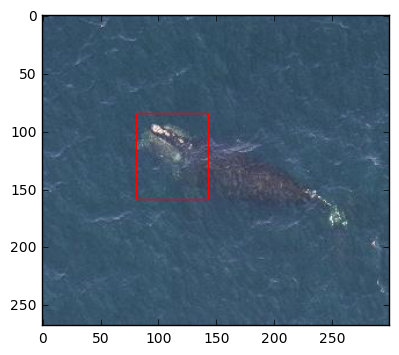

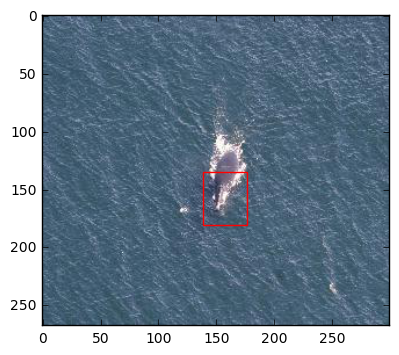

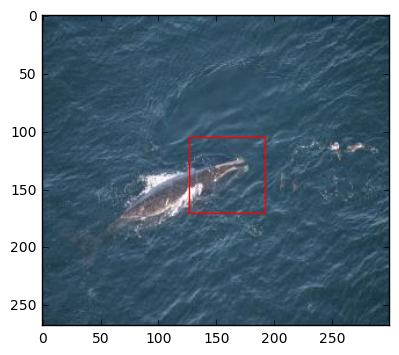

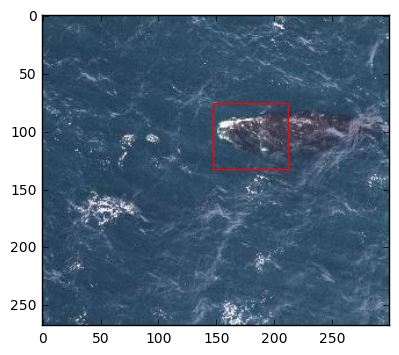

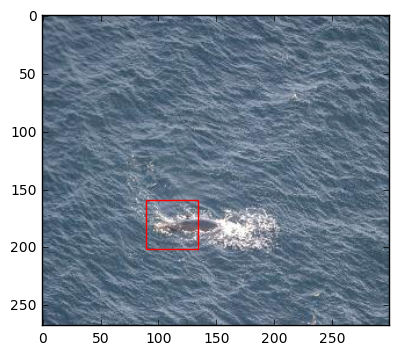

In [81]:
samp = ann.sample(frac=0.001)

for r in samp.iterrows():
    check(r, TARGET_WIDTH, TARGET_HEIGHT, output_dir)